# Text Classification using Spacy (NLP)

### Job Fraud Detection 

Number of Fake jobs posted on the internet is increasing alarmingly every day. Even though most of the times fake job post will not do much harm, it surely leads to data leakage. It is not always easy to spot fake jobs from thousands of jobs posted. In this exercise we try to classify fake jobs and real jobs using Natural Language Processing (Spacy) and Machine Learning Models.

*Importing all the neccessary libraries* 

In [1]:
# import the libraries

import pandas as pd
import numpy as np

import os
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from collections import Counter
import spacy
import string

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,precision_score,recall_score 
from sklearn.metrics import plot_confusion_matrix ,classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score,roc_curve, f1_score

from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC

### Importing Data and Exploring the Data

*Data Wrangling and Visualization using seaborn*

In [2]:
#os.chdir('C:/Users/Tilbin/Desktop/Learning/Data Sets')

In [3]:
data= pd.read_csv("fake_job_postings.csv")


print('shape',data.shape)

shape (17880, 18)


> * We can see that the data has 17880 rows and 18 columns.

In [4]:
data.dtypes

job_id                  int64
title                  object
location               object
department             object
salary_range           object
company_profile        object
description            object
requirements           object
benefits               object
telecommuting           int64
has_company_logo        int64
has_questions           int64
employment_type        object
required_experience    object
required_education     object
industry               object
function               object
fraudulent              int64
dtype: object

> * The columns *'job_id'*, *'telecommuting'*, *'has_company_logo'*, *'has_questions'* have numeric values as you can see their data type is int. There 4 columns will not be useful in our text classification problem so we can delete those columns them later. The column *'fraudulent'* is the dependent variable our model is going to be trained upon for prediction.

In [5]:
data.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


0    17014
1      866
Name: fraudulent, dtype: int64


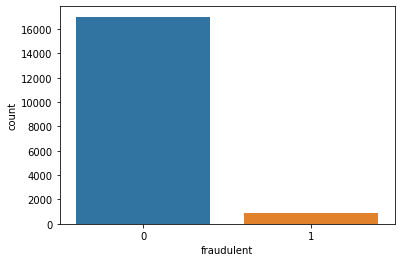

In [6]:
# checking for the number of fake and real jobs in the data 

print(data['fraudulent'].value_counts())
sns.countplot(data['fraudulent'])

> * Fraudulent column contains just two values were 0 is non fraudelent jobs posted and 1 is the jobs classified as frauds.
We can see that a very few fake jobs are there in the data set. The data we have is highly <font color=blue> imbalanced</font>  which could affect the performance of the classification model.


fraudulent  employment_type
0           Contract            1480
            Full-time          11130
            Other                212
            Part-time            723
            Temporary            239
1           Contract              44
            Full-time            490
            Other                 15
            Part-time             74
            Temporary              2
Name: title, dtype: int64


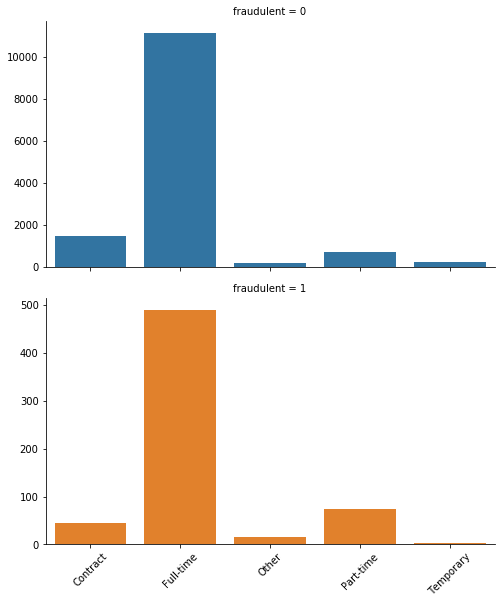

In [7]:
# Jobs posted for different employment types 

print(data.groupby(['fraudulent','employment_type']).count()['title'])

def fraudplot():
    a=data.groupby(['fraudulent','employment_type']).count()['title'].reset_index().sort_values(by='fraudulent',ascending = True)
    fig= sns.FacetGrid(a,row='fraudulent',hue='fraudulent',sharey=False,height=4)
    fig.map_dataframe(sns.barplot,x='employment_type',y='title')
    fig.set_xticklabels(rotation=45)
    fig.fig.set_figwidth(8)
    

fraudplot()


US - 10656
GB - 2384
GR - 940
CA - 457
DE - 383
NZ - 333
IN - 276
AU - 214
PH - 132
NL - 127


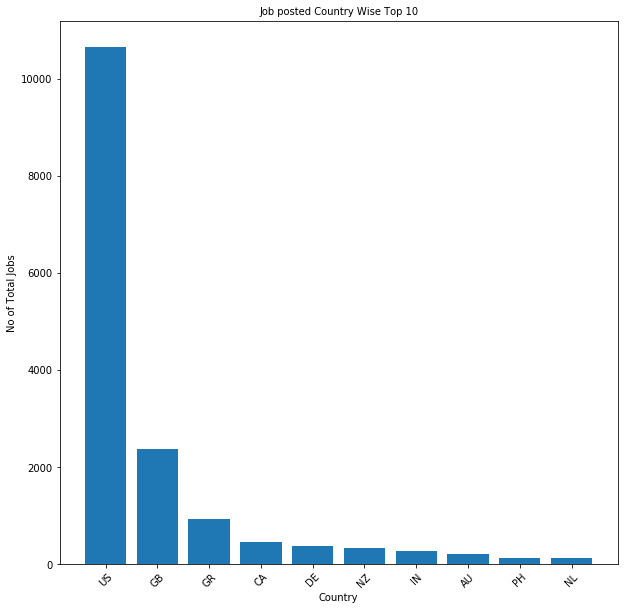

In [8]:
# we can check the top 10 countries who posts the most number of jobs and to do that we have to split the location variable


def country(name):
    data['country']=data[name].fillna('').apply(lambda x: x.split(',')[0]) 
    countries= dict(data['country'][data['country'].apply(lambda x: x!='')].value_counts()[:10])
    for k,v in countries.items():
        print(f'{k} - {v}')
    plt.figure(figsize=(10,10))
    plt.title('Job posted Country Wise Top 10',size=10)
    plt.bar(countries.keys(),countries.values())
    plt.ylabel('No of Total Jobs')
    plt.xlabel('Country')
    plt.xticks(rotation=45)


country('location')

> * US posts the most number of jobs in our data.

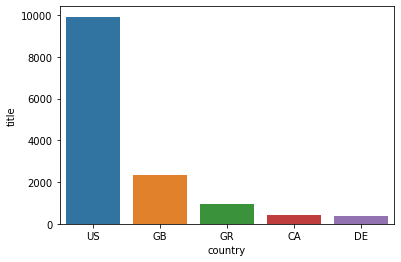

In [9]:
# Top 5 countries that post the most number of real jobs 

real_job_countries=data[data['fraudulent']==0].groupby(['country','fraudulent']).count()['title'].reset_index().sort_values(by='title',ascending=False).reset_index(drop=True)[:5]


sns.barplot(data=real_job_countries,x="country",y="title")


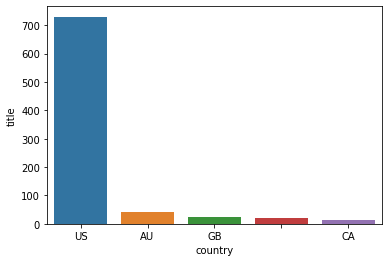

In [10]:
# Top 5 countries that post the most number of fake jobs

fake_job_countries=data[data['fraudulent']==1].groupby(['country','fraudulent']).count()['title'].reset_index().sort_values(by='title',ascending=False).reset_index(drop=True)[:5]

sns.barplot(data=fake_job_countries,x="country",y="title")


> * Most number of real and fake jobs are posted in US.
> * Here in top 5 countries that post fake jobs we can see that a bar without a label, it is that the data has missing values. 

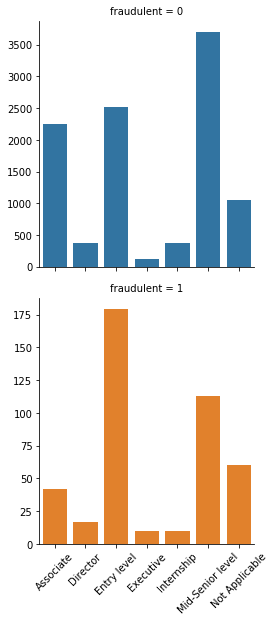

In [11]:
# fake jobs (1) and real jobs (0) numbers for each experienced required

def experience_plot(f,r,t):
    experience_req= data.groupby([f,r]).count()[t].reset_index().sort_values(by=[r],ascending=True)
    fig = sns.FacetGrid(experience_req,row=f,hue=f,sharey=False,height=4)
    fig.map_dataframe(sns.barplot,x=r,y=t)
    fig.set_xticklabels(rotation=45)

experience_plot('fraudulent','required_experience','title')

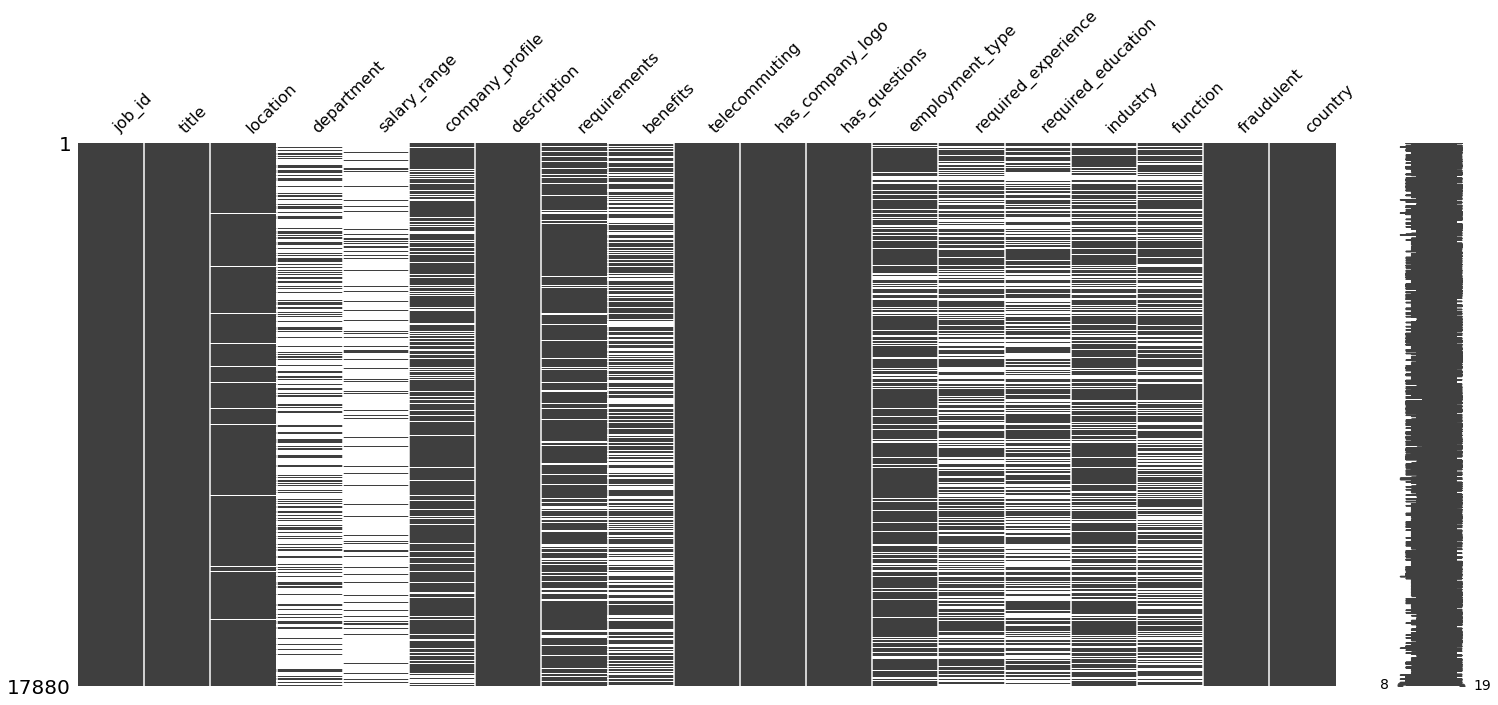

In [12]:
# looking for missing values in the data

msno.matrix(data)


> * There are missing values in our data

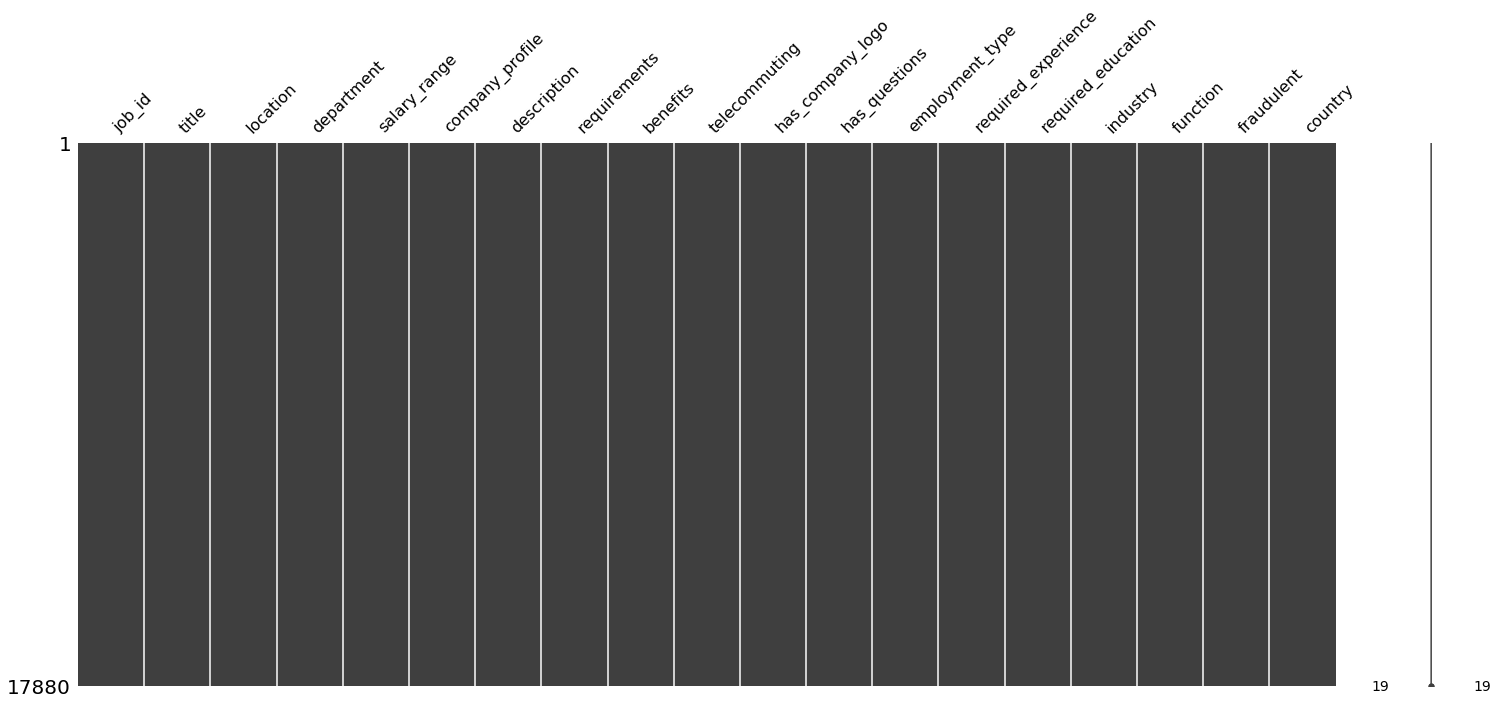

In [13]:
# we replace all the missing values with empty strings.


data=data.fillna('')
msno.matrix(data)

In [14]:
 # we combine all the text variables in a single column and drop every other variable.

data['text']=data['title']+' '+data['location']+' '+data['department']+' '+data['company_profile']+' '+data['requirements']+' '+data['benefits']+' '+data['employment_type']+' '+data['required_experience']+' '+ data['required_education']+' '+data['industry']+' '+data['function']


def delcol(*name):
    for i in name:
        del data[i]

delcol('job_id','title','location','department','salary_range','company_profile','description','requirements','benefits','telecommuting', 'has_company_logo', 'has_questions','employment_type','required_experience', 'required_education', 'industry','function','country')

data.head()

print(data['text'][0])
    

Marketing Intern US, NY, New York Marketing We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Experience with content management systems a major plus (any blogging 

## Cleaning the text data using Spacy

In [15]:
# we tokenize the sentences, remove stop words, lower the words...

# we load the punctuation character and stopwords

punct= string.punctuation
print('punctuation: ', punct)

## you can create custom stop words and all it to this
stopwords= list(STOP_WORDS)
print('\nstopwords: ', stopwords)


punctuation:  !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

stopwords:  ['therein', 'somewhere', 'otherwise', 'keep', 'might', 'however', '’s', 'must', 'while', 'with', 'or', 'whereupon', 'thru', 'first', 'and', 'among', 're', 'towards', '‘re', 'since', 'herein', 'of', 'other', 'take', 'about', 'least', 'thereafter', 'from', 'for', 'somehow', 'hundred', 'whatever', 'eleven', "'ll", 'why', 'call', 'where', 'indeed', 'although', 'used', 'beside', 'wherein', 'should', 'give', 'all', 'well', 'this', 'nor', 'none', 'move', 'perhaps', 'get', 'herself', 'below', 'everywhere', 'really', 'serious', 'except', 'either', 'that', 'two', 'alone', 'there', 'sometimes', 'back', 'five', 'fifteen', 'whence', 'same', 'have', "'re", 'next', 'them', 'each', 'do', 'no', 'ourselves', 'any', 'always', 'ten', 'they', 'bottom', 'top', 'whereas', 'whereby', 'say', 'whereafter', 'me', 'now', 'out', 'these', 'enough', 'were', 'n‘t', 'everything', 'being', 'namely', 'various', 'done', 'very', 'did', 'within', 'us', 'ca', 'ofte

In [16]:
# we use the medium english model of spacy to load the nlp object

nlp= spacy.load("en_core_web_md")

def text_clean(text):
    doc=nlp(text)
    
    tokens=[]
    for token in doc:
        if token.lemma_ !="-PRON-":
            tok= token.lemma_.lower().strip()
        else:
            tok=token.lower_
        tokens.append(tok)
        
    cleaned_tokens=[]
    for token in tokens:
        if token not in stopwords and token not in punct :
            cleaned_tokens.append(token)
    return cleaned_tokens


In [17]:
# Split the data into train and test data

X= data['text']
y=data['fraudulent']


X_train, X_test, y_train, y_test= train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

print(X_train.shape,X_test.shape)

print('\n',sum(y_train)/len(y_train))
print('\n',sum(y_test)/len(y_test))


(12516,) (5364,)

 0.048418024928092045

 0.048471290082028336


> * When splitting the dataset we used a stratify parameter for the y/dependent variable because our data is highly imbalanced and we want to maintain the same proportion of each classes in both test and train datas.
> * We can check it by counting the y samples (where it sums all the 1s) and then divide it by the total length. And we can see that both train and test split has the same proportion of 1s.

In [18]:
# Creating a tfidf vectorizer

tfidf= TfidfVectorizer(tokenizer=text_clean)


> * Tfidf vectorizer vectorizes the tokens based on the relevance of the word.
> * More powerful unsupervised approaches such as Word2Vec, GloVec, BERT etc are used in the industry now.

## Creating the model  

Here to do the classification problem i chose LinearSVC Support Vector Machine, Gradient Boosting Classifier XGBoostClassifier, and a tree based classifier RandomForestClassifier.

We create a Pipeline, fits and predicts the data. 

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5104
           1       0.97      0.78      0.86       260

    accuracy                           0.99      5364
   macro avg       0.98      0.89      0.93      5364
weighted avg       0.99      0.99      0.99      5364

[[5098    6]
 [  58  202]]

 LinearSVC Accuracy Score:  0.9880686055182699

 LinearSVC Precision Score:  0.9711538461538461

 LinearSVC Recall Score:  0.7769230769230769

 LinearSVC ROC_AUC Score:  0.8878737641668676


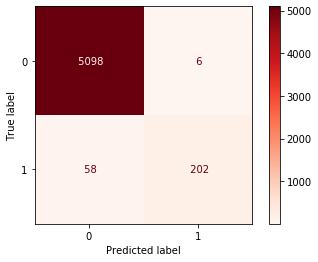

In [19]:
# LinearSVC Support Vector Machine

classifier=LinearSVC()

clf= Pipeline([('tfidf',tfidf),('clf',classifier)])

clf.fit(X_train,y_train)

y_pred= clf.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test,y_pred))
print('\n','LinearSVC Accuracy Score: ',accuracy_score(y_test,y_pred))
print('\n','LinearSVC Precision Score: ',precision_score(y_test,y_pred))
print('\n','LinearSVC Recall Score: ',recall_score(y_test,y_pred))
print('\n','LinearSVC ROC_AUC Score: ',roc_auc_score(y_test,y_pred))


plot_confusion_matrix(clf,X_test,y_test,cmap='Reds',values_format=' ')



> * For our LinearSVC we have a very good accuracy score of 98.8% percent, but since our data is highly imbalanced we look at the Recall and Precision. Our model correctly predicted 78% of the fake jobs, which is not the worst considering the total number of fake jobs in our data. And we have a very high precision score as well with 97% ie, out of the 208 fake jobs predicted by our model 202 were actually correct predictions.   

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      5104
           1       0.97      0.75      0.85       260

    accuracy                           0.99      5364
   macro avg       0.98      0.88      0.92      5364
weighted avg       0.99      0.99      0.99      5364

[[5098    6]
 [  64  196]]

 XGBClassifier Accuracy Score:  0.9869500372856077

 XGBClassifier Precision Score:  0.9702970297029703

 XGBClassifier Recall Score:  0.7538461538461538

 XGBClassifier ROC_AUC Score:  0.8763353026284061


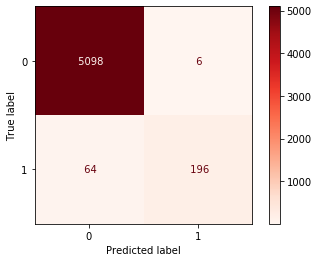

In [20]:
# XGBoost Classifier

xgbclassifier= XGBClassifier()

xgbclf= Pipeline([('tfidf',tfidf),('xgbclf',xgbclassifier)])

xgbclf.fit(X_train,y_train)

y_predxgb= xgbclf.predict(X_test)

print(classification_report(y_test,y_predxgb))
print(confusion_matrix(y_test,y_predxgb))
print('\n','XGBClassifier Accuracy Score: ',accuracy_score(y_test,y_predxgb))
print('\n','XGBClassifier Precision Score: ',precision_score(y_test,y_predxgb))
print('\n','XGBClassifier Recall Score: ',recall_score(y_test,y_predxgb))
print('\n','XGBClassifier ROC_AUC Score: ',roc_auc_score(y_test,y_predxgb))

plot_confusion_matrix(xgbclf,X_test,y_test,cmap='Reds',values_format=' ')


> * Here for the XGBoostClassifier we have an Accuracy of 98.6% and a Precision Score of 97% and Recall Score of 75.3. We can see that the model predicted the same number of real jobs as the LinearSVC but failed to correctly predict some of the fake jobs.

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      5104
           1       1.00      0.67      0.80       260

    accuracy                           0.98      5364
   macro avg       0.99      0.84      0.90      5364
weighted avg       0.98      0.98      0.98      5364

[[5104    0]
 [  85  175]]

 Random Forest Classifier Accuracy Score:  0.9841536167039523

 Random Forest Classifier Precision Score:  1.0

 Random Forest Classifier Recall Score:  0.6730769230769231

 Random Forest Classifier ROC_AUC Score:  0.8365384615384616


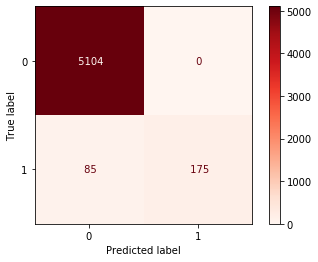

In [21]:
# RandomForest Classifier

randforclass= RandomForestClassifier()

rfcclf=Pipeline([('tfidf',tfidf),('rfcclf',randforclass)])

rfcclf.fit(X_train,y_train)

y_predrfc=rfcclf.predict(X_test)

print(classification_report(y_test, y_predrfc))
print(confusion_matrix(y_test,y_predrfc))
print('\n','Random Forest Classifier Accuracy Score: ',accuracy_score(y_test,y_predrfc))
print('\n','Random Forest Classifier Precision Score: ',precision_score(y_test,y_predrfc))
print('\n','Random Forest Classifier Recall Score: ',recall_score(y_test,y_predrfc))
print('\n','Random Forest Classifier ROC_AUC Score: ',roc_auc_score(y_test,y_predrfc))

plot_confusion_matrix(rfcclf,X_test,y_test,cmap='Reds',values_format=' ')

> * The RandomForestClassifier has an Accuracy Score of 98.4 and we have a 100% Precision Score and 67% Recall Score. Our model correctly predicted all the real jobs but showed poor performance in fake job prediction. A 100% Precision might also be that the model is overfitting class 0. 

> * Since the models have a very good Accuracy, Precision and Recall Scores we use another metric called ROC_AUC Score and f1-Score to determine which model performs the best in classifying our problem. 

## ROC AUC Curve and F1-Score for Model Selection

ROC AUC Curve in short words is that it tells us how good a model can distinguish between two classes. Better the score better the model can distinguish the two classes. F1-Score is the harmonic mean of Precision and Recall. When different models have different Precision and Recall Scores say model 1 has better Precision Score and Model 2 has a better Recall Score, it will be confusing to select a better model. F1 scores are generally helpful in those cases.

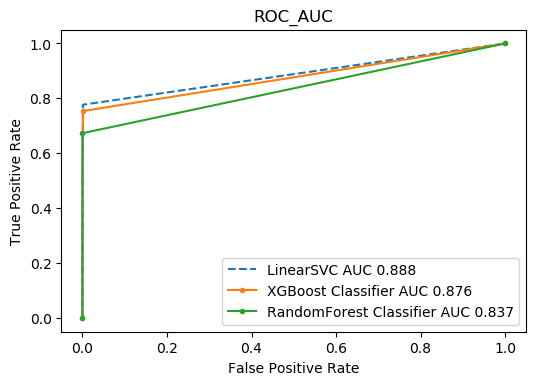

In [22]:
# To plot the ROC_AUC Curve we need to calculate the ROC Curve

#roc_auc_scores or area under the curve
aucSVC= roc_auc_score(y_test,y_pred)
aucXGB= roc_auc_score(y_test,y_predxgb)
aucRFC= roc_auc_score(y_test,y_predrfc)

#False positive rates and true positive rates
svc_fpr,svc_tpr,threshold= roc_curve(y_test,y_pred)
sgb_fpr,xgb_tpr,threshold= roc_curve(y_test,y_predxgb)
rfc_fpr, rfc_tpr,threshold= roc_curve(y_test,y_predrfc)

#plotting the graph

plt.figure(dpi=100)
plt.plot(svc_fpr,svc_tpr,linestyle='--',label="LinearSVC AUC %0.3f" %aucSVC)
plt.plot(sgb_fpr,xgb_tpr,marker='.',label="XGBoost Classifier AUC %0.3f" %aucXGB)
plt.plot(rfc_fpr, rfc_tpr,marker='.',label="RandomForest Classifier AUC %0.3f" %aucRFC)

plt.title("ROC_AUC")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()



> * Looking at the graph we can see that the Linear SVC model has a better AUC Score and is also more close to the one on the graph followed by XGBoost and RandomForest. 

In [23]:
# f1-Scores for the models

print('F1 Score for LinearSVC Model is: %0.3f' %f1_score(y_test,y_pred))
print('F1 Score for XGBoost Model is: %0.3f' %f1_score(y_test,y_predxgb))
print('F1 Score for RandomForest Model is: %0.3f' %f1_score(y_test,y_predrfc))



F1 Score for LinearSVC Model is: 0.863
F1 Score for XGBoost Model is: 0.848
F1 Score for RandomForest Model is: 0.805


> * LinearSVC has the greatest f1-score followed by XGBoost and Random Forest. If we take both Roc_Auc and F1 Scores, Linear SVC has the best score therefor we can select it as the Best model of the three

Imbalanced data can be a serious problem when building a machine learning model. Your model might completely ignore the class with few data point while giving a very good accuracy. Try if you can get more data for the problem or there are a few uselful ways to  deal with imbalanced data sets. **UnderSampling** - under sampling of majority class, **OverSampling** - over sampling of minority class by duplicating it, **SMOTE(Synthetic Minority Over Sampling TEchnique)** -  it generates new minority data points rather than duplicating it, are a few of them. Oversampling and undersampling are not the best approaches to do at times because the first one can cause overfitting and the later one can cause data wastage. However sklearn has an argument called class_weights to deal with imbalanced classes which is also great. You can try K-Fold Cross Validation and Hyperparameter tuning for you model to deal with this problem.